# Loading modules

In [8]:
import xarray as xr
import numpy as np
import sys
from glob import glob
import gc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('../../../')
"""
local scripts, if loading from a different directory include that with a '.' between
directory name and script name
"""
from tropical_PODs.PODs.POD_utils import calculate_saturation_specific_humidity
from tropical_PODs.PODs.POD_utils import numerical_plume_model
from tropical_PODs.PODs.POD_utils import calculate_CAPE

# Define input directories and file names

In [9]:
##################
###.  DYNAMO.  ###
##################

ifile_DYNAMO_NSA = '../../../tropical_PODs/data/dynamo_nsa_v3b.nc' 

ifile_TRMM_NSA = '../../../tropical_PODs/data/trmm_rain.txt' 

# Define output directories

In [17]:
# Output directory for datasets
odir_datasets = '../../../tropical_PODs/examples/ofiles_examples/'

# Output directory for datasets
odir_plots = '../../../tropical_PODs/examples/oplots_examples/'

# Define constants

In [11]:
g = 9.8 # [m s^-2]

# Driver for DYNAMO calculations

In [12]:
############################
####  Load DYNAMO Data  ####
############################

# Data is "lazy loaded", nothing is actually loaded until we "look" at data in some way #

dataset_DYNAMO_NSA = xr.open_dataset(ifile_DYNAMO_NSA)
dataset_DYNAMO_NSA.load()

dataset_TRMM_NSA = pd.read_csv(ifile_TRMM_NSA, header=None, delim_whitespace=True, names=['yymmddhh', 'nsa', 'ssa', 'colombo', 'male', 'gan', 'revelle', 'diego', 'mirai', 'manus',\
                                                                                                      'num_grid_points_nsa', 'num_grid_points_ssa', 'num_grid_points_colombo', 'num_grid_points_male',\
                                                                                                      'num_grid_points_gan', 'num_grid_points_revelle', 'num_grid_points_diego', 'num_grid_points_mirai', 'num_grid_points_manus'])
dataset_TRMM_NSA_precipitation = dataset_TRMM_NSA.nsa.values[:-1].astype('float32')
dataset_TRMM_NSA_time = dataset_TRMM_NSA.yymmddhh.values[:-1]
dataset_TRMM_NSA_time = pd.to_datetime(dataset_TRMM_NSA_time,yearfirst=True,format='%y%m%d%H').to_pydatetime()

precipitation = xr.DataArray(dataset_TRMM_NSA_precipitation,coords=dict(time=dataset_TRMM_NSA_time),dims='time',name='precipitation', attrs={'units':'[mm day^-1]'})
precipitation.load()

###############################
####  Rename Level to Lev  ####
###############################

dataset_DYNAMO_NSA = dataset_DYNAMO_NSA.rename({'level':'lev'}).sortby('lev', ascending=True)

######################################
####  Extract Desired Variables  ####
######################################

PS = dataset_DYNAMO_NSA['ps'] * 100 # To convert from [hPa] to [Pa]
T = dataset_DYNAMO_NSA['T'] + 273.15 # To convert from [C] to [K]
RH = dataset_DYNAMO_NSA['rh']/100 # To convert from [%] to [Kg/Kg]

# Clean up environment #
    
gc.collect();

#########################################################
####  Limit Data to 1000 hPa for Plume Calculations  ####
#########################################################

T = T.sel(lev=slice(50,1000))
RH = RH.sel(lev=slice(50,1000))

################################################################
####  Calculate Pressure at Level Midpoints and Interfaces  ####
################################################################

print("Calculating true model pressure")
    
# Set upper most interface equal to uppermost level midpoint, and lowest interface equal to surface pressure.
# This will still permit the desired vertical integral, just choose appropriate upper and lower integration limits
    
# Model level midpoint

true_pressure_midpoint = T['lev'] * 100. # To convert to Pa
true_pressure_midpoint = true_pressure_midpoint.rename('true_pressure_midpoint_Pa')
true_pressure_midpoint = true_pressure_midpoint.expand_dims({'time':T['time']})
true_pressure_midpoint = true_pressure_midpoint.transpose('time','lev')
    
# Model level interfaces
    
true_pressure_interface = np.empty((len(T.time),len(T.lev)+1))

for interface_level_counter in range(len(T.lev) + 1):
    if interface_level_counter == 0:
        true_pressure_interface[:,interface_level_counter] = T['lev'].isel(lev=0).values # Set upper most interface equal to uppermost level midpoint
    elif interface_level_counter == (len(T.lev)):
        true_pressure_interface[:,interface_level_counter] = T['lev'].isel(lev=-1).values # Set lowest interface equal to lowest level midpoint
    else:
        true_pressure_interface[:,interface_level_counter] = (T['lev'].isel(lev=interface_level_counter-1).values + T['lev'].isel(lev=interface_level_counter).values) / 2.,  # Set middle interfaces equal to half way points between level midpoints
            
coords = {'time':T['time'], 'ilev':np.arange(1,len(T.lev) + 2)}
dims = ['time', 'ilev']
true_pressure_interface = xr.DataArray(true_pressure_interface,dims=dims,coords=coords) * 100. # To convert to Pa
true_pressure_interface.attrs['units'] = 'Pa'      
    
true_pressure_interface = true_pressure_interface.transpose('time','ilev')

# Clean up environment #
    
gc.collect();
  
##################################################
####  Calculate Saturation Specific Humidity  ####
##################################################

print("Calculating saturation specific humidity")

saturation_specific_humidity = xr.apply_ufunc(calculate_saturation_specific_humidity, true_pressure_midpoint, T, output_dtypes=[T.dtype])

# Clean up environment #
    
gc.collect();

#######################################
####  Calculate Specific Humidity  ####
#######################################
            
Q = saturation_specific_humidity * RH
            
################################
####  Average Data to Daily ####
################################
                
PS = PS.resample(time='1D').mean('time')
Q = Q.resample(time='1D').mean('time')
T = T.resample(time='1D').mean('time')
precipitation = precipitation.resample(time='1D').mean('time')
true_pressure_midpoint = true_pressure_midpoint.resample(time='1D').mean('time')
true_pressure_interface = true_pressure_interface.resample(time='1D').mean('time')
 
##########################
####  Run Plume Model ####
##########################
    
launch_level_hPa = 1000 # [hPa] per Fiaz's code. Must remain close to 1000 to maintain mass flux profile
                
Tv_env, Tv_plume_DIB, Tv_plume_NOMIX, c_mix_DIB = numerical_plume_model(T, Q, 1000)
                
##########################
####  CAPE Variables  ####
##########################
    
# print('Calculating CAPE Variables')
                
CAPE_DIB_1000_to_600 = calculate_CAPE(Tv_env, Tv_plume_DIB, true_pressure_midpoint, true_pressure_interface , 100000, 60000)
                
CAPE_NOMIX_1000_to_600 = calculate_CAPE(Tv_env, Tv_plume_NOMIX, true_pressure_midpoint , true_pressure_interface , 100000, 60000)
                
                
CAPE_DIB_1000_to_850 = calculate_CAPE(Tv_env, Tv_plume_DIB, true_pressure_midpoint , true_pressure_interface , 100000, 85000)

CAPE_NOMIX_1000_to_850 = calculate_CAPE(Tv_env, Tv_plume_NOMIX, true_pressure_midpoint , true_pressure_interface , 100000, 85000)
                
                
CAPE_DIB_850_to_600 = calculate_CAPE(Tv_env, Tv_plume_DIB, true_pressure_midpoint , true_pressure_interface , 85000, 60000)
                
CAPE_NOMIX_850_to_600 = calculate_CAPE(Tv_env, Tv_plume_NOMIX, true_pressure_midpoint , true_pressure_interface , 85000, 60000)    

# Name variables #

CAPE_DIB_1000_to_600.name = 'CAPE_DIB_1000_to_600'
CAPE_NOMIX_1000_to_600.name = 'CAPE_NOMIX_1000_to_600'
    
CAPE_DIB_1000_to_850.name = 'CAPE_DIB_1000_to_850'
CAPE_NOMIX_1000_to_850.name = 'CAPE_NOMIX_1000_to_850'
    
CAPE_DIB_850_to_600.name = 'CAPE_DIB_850_to_600'
CAPE_NOMIX_850_to_600.name = 'CAPE_NOMIX_850_to_600'
    
# Add desired attributes #

CAPE_DIB_1000_to_600.attrs['Units'] = '[J Kg^-1]'
CAPE_NOMIX_1000_to_600.attrs['Units'] = '[J Kg^-1]'
    
CAPE_DIB_1000_to_850.attrs['Units'] = '[J Kg^-1]'
CAPE_NOMIX_1000_to_850.attrs['Units'] = '[J Kg^-1]'
    
CAPE_DIB_850_to_600.attrs['Units'] = '[J Kg^-1]'
CAPE_NOMIX_850_to_600.attrs['Units'] = '[J Kg^-1]'
        
# Clean up environment #
    
gc.collect();


Calculating true model pressure
Calculating saturation specific humidity


# Define plotting functions

# Plotting Individual Tv Profiles

In [13]:
def plot_Tv_profile(Tv_env, Tv_plume_DIB, Tv_plume_NOMIX, x_axis_limits=(), y_axis_limits=(),x_axis_label='Tv', y_axis_label='', save_fig_boolean=False, figure_path_and_name='untitled.png'):
    
    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(Tv_env, Tv_env.lev, color='k',linestyle='solid', linewidth=7)
    ax1.plot(Tv_plume_NOMIX, Tv_plume_NOMIX.lev, color='k',linestyle='dashed', linewidth=5)
    ax1.plot(Tv_plume_DIB, Tv_plume_DIB.lev, color='k',linestyle='dotted', linewidth=5)

    ax1.fill_betweenx(Tv_env.lev,Tv_env, Tv_plume_DIB, color='blue')
    ax1.fill_betweenx(Tv_env.lev,Tv_env, Tv_plume_NOMIX,color='red')

    ax1.set_xlabel(x_axis_label, fontdict={'size':24,'weight':'bold'})
    ax1.set_ylabel(y_axis_label, fontdict={'size':24,'weight':'bold'})

    if len(x_axis_limits)==2:
        ax1.set(xlim=x_axis_limits)
    else:
        ax1.set(xlim=(Tv_env.min(), Tv_env.max()))

    if len(y_axis_limits)==2:
        ax1.set(ylim=y_axis_limits)
    else:
        ax1.set(ylim=(Tv_env.min(), Tv_env.max()))

    #ax1.plot((0,5), (600,600), color='k',linestyle='dotted', linewidth=3)
    #ax1.plot((0,50), (850,850), color='k',linestyle='dashed', linewidth=3)

    ax1.tick_params(axis="x", direction="in", length=8, width=2, color="black")
    ax1.tick_params(axis="y", direction="in", length=8, width=2, color="black")

    ax1.tick_params(axis="x", labelsize=18, labelrotation=0, labelcolor="black")
    ax1.tick_params(axis="y", labelsize=18, labelrotation=0, labelcolor="black")

    for tick in ax1.xaxis.get_majorticklabels():
        tick.set_fontsize(18)
        tick.set_fontweight('bold')
    
    for tick in ax1.yaxis.get_majorticklabels():
        tick.set_fontsize(18) 
        tick.set_fontweight('bold')
    
    if save_fig_boolean:
        plt.savefig(figure_path_and_name, dpi=1000, facecolor='w', edgecolor='w',
                    orientation='portrait', format='png',
                    transparent=False, bbox_inches='tight', pad_inches=0.0, metadata=None)
    
   

# Plotting Timeseries of DYNAMO Profiles

In [14]:
def plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits=(), y_axis_limits=(), x_axis_label='Binning Variable 1', y_axis_label='Binning Variable 2', log_Y_axis_boolean=False, plot_precipitation_boolean=False, precipitation=[], precipitation_y_axis_limits=(), precipitation_y_axis_label = '', save_fig_boolean=False, figure_path_and_name='untitled.png'):
    
    color_shading_var = color_shading_var.transpose('lev','time')

    fig = plt.figure(figsize=(30, 10))

    # Ask for, out of a 1x1 grid, the first axes #

    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(x_axis_label, fontdict={'size':24,'weight':'bold'})
    ax.set_ylabel(y_axis_label, fontdict={'size':24,'weight':'bold'})

    if len(x_axis_limits)==2:
        ax.set(xlim=x_axis_limits)
    else:
        ax.set(xlim=(bin_number_of_samples_centered.BV1_bin_midpoint.min(), bin_number_of_samples_centered.BV1_bin_midpoint.max()))

    if len(y_axis_limits)==2:
        ax.set(ylim=y_axis_limits)
    else:
        ax.set(ylim=(bin_number_of_samples_centered.min(), bin_number_of_samples_centered.max()))

    # Axis Ticks #

    ax.tick_params(axis="x", direction="in", length=12, width=3, color="black")
    ax.tick_params(axis="y", direction="in", length=12, width=3, color="black")

    ax.tick_params(axis="x", labelsize=18, labelrotation=0, labelcolor="black")
    ax.tick_params(axis="y", labelsize=18, labelrotation=0, labelcolor="black")

    for tick in ax.xaxis.get_majorticklabels():
        tick.set_fontsize(18)
        tick.set_fontweight('bold')
        
    for tick in ax.yaxis.get_majorticklabels():
        tick.set_fontsize(18) 
        tick.set_fontweight('bold')

    if log_Y_axis_boolean:

        ax.set_yscale("log")

    # Create "meshgrid" for contour plotting #

    BV1_bin_midpoint_meshgrid, BV2_bin_midpoint_meshgrid = np.meshgrid(color_shading_var.time, color_shading_var.lev)

    BV1_bin_midpoint_meshgrid_DA = color_shading_var.copy()
    BV1_bin_midpoint_meshgrid_DA.values = BV1_bin_midpoint_meshgrid

    BV2_bin_midpoint_meshgrid_DA = color_shading_var.copy()
    BV2_bin_midpoint_meshgrid_DA.values = BV2_bin_midpoint_meshgrid

    # Contourf #

    c = ax.contourf(BV1_bin_midpoint_meshgrid_DA, BV2_bin_midpoint_meshgrid_DA, color_shading_var, levels=color_shading_levels,cmap=color_shading_map, vmin=color_shading_levels.min(), vmax=color_shading_levels.max(), extend=colorbar_extend_string)

    # Plotting Precipitation #

    if plot_precipitation_boolean:
        ax2 = ax.twinx()
        ax2.plot(precipitation.time, precipitation, color='k',linestyle='solid', linewidth=5)

        ax2.set_ylabel(precipitation_y_axis_label, fontdict={'size':24,'weight':'bold'})
        ax2.set(xlim=x_axis_limits, ylim=precipitation_y_axis_limits)

        ax2.tick_params(axis="x", direction="in", length=8, width=2, color="black")
        ax2.tick_params(axis="y", direction="in", length=8, width=2, color="black")

        ax2.tick_params(axis="x", labelsize=18, labelrotation=0, labelcolor="black")
        ax2.tick_params(axis="y", labelsize=18, labelrotation=0, labelcolor="black")

        for tick in ax2.xaxis.get_majorticklabels():
            tick.set_fontsize(18)
            tick.set_fontweight('bold')

        for tick in ax2.yaxis.get_majorticklabels():
            tick.set_fontsize(18) 
            tick.set_fontweight('bold')

    # Colorbar # 
        
    if scientific_colorbar_boolean:
        # Colorbar # 
        fmt = tkr.ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((0, 0))
        
        cbar = fig.colorbar(c, ax=ax, orientation="horizontal", pad=0.14, format=fmt)
        cbar.set_ticks(colorbar_tick_levels)
        cbar.ax.get_yaxis().labelpad = 0
        cbar.set_label(colorbar_label_string, rotation=0, fontdict={'size':18,'weight':'bold'})
        for tick in cbar.ax.xaxis.get_majorticklabels():
            tick.set_fontsize(18) 
            tick.set_fontweight('bold')
        cbar_ax = fig.axes[-1]
        cbar_ax.tick_params(length=10,direction='in')
        
        cbar.ax.xaxis.offsetText.set_fontsize(22)
        cbar.ax.xaxis.offsetText.set_fontweight('bold')
            
    else:
        cbar = fig.colorbar(c, ax=ax, orientation="horizontal", pad=0.125)
        cbar.set_ticks(colorbar_tick_levels)
        cbar.ax.get_yaxis().labelpad = 0
        cbar.set_label(colorbar_label_string, rotation=0, fontdict={'size':24,'weight':'bold'})
        for tick in cbar.ax.xaxis.get_majorticklabels():
            tick.set_fontsize(18) 
            tick.set_fontweight('bold')
        cbar_ax = fig.axes[-1]
        cbar_ax.tick_params(length=10,direction='in')
            
    # Save figure #
        
    if save_fig_boolean:
        plt.savefig(figure_path_and_name, dpi=1000, facecolor='w', edgecolor='w',
                    orientation='portrait', format='png',
                    transparent=False, bbox_inches='tight', pad_inches=0.0,
                    metadata=None)
   

# Driver for plotting

In [15]:
# Define colormap # 

colors = [(10, 50, 120), (15, 75, 165), (30, 110, 200), (60, 160, 240), (80, 180, 250), (130, 210, 255), (160, 240, 255), (200, 250, 255), (230, 255, 255), (230, 230, 230), (230, 230, 230), (255, 250, 220), (255, 232, 120), (255, 192, 60), (255, 160, 0), (255, 96, 0), (255, 50, 0), (225, 20, 0), (192, 0, 0), (165, 0, 0)]
for list_index in range(len(colors)):
    colors[list_index] = tuple(tuple_element/255. for tuple_element in colors[list_index])
        
n_bin = 200
cmap_name = 'colors'
colormap_colors = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

# Environmental versus plume vitrual temperature at t = 0 

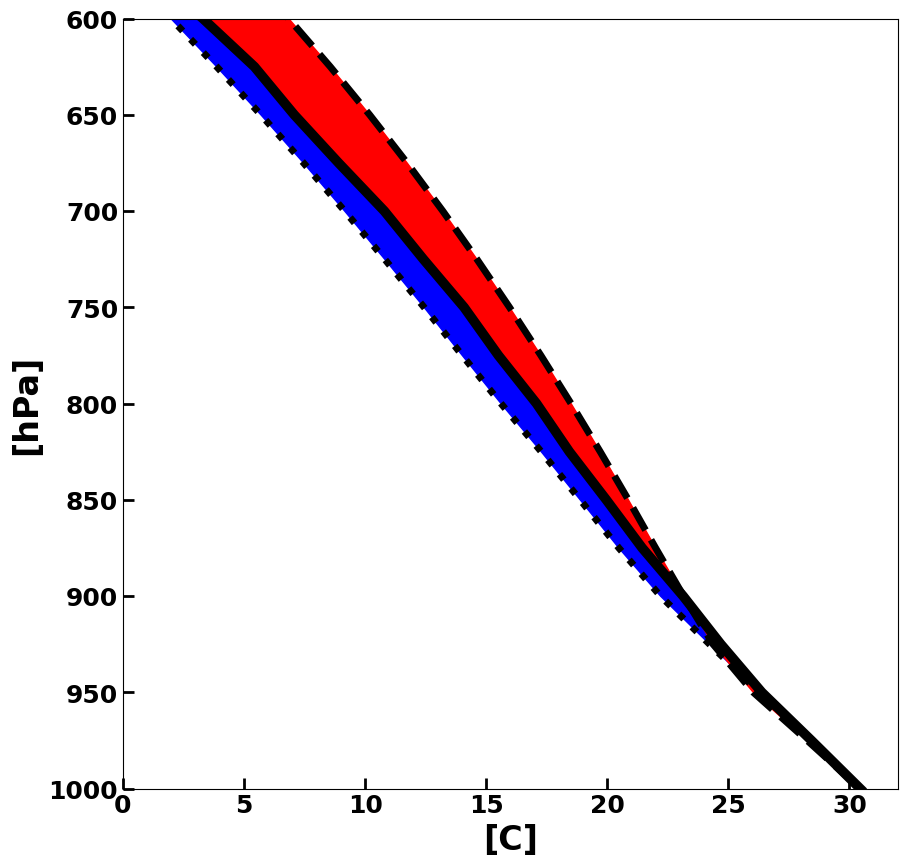

In [18]:
x_axis_limits=(0,32)
y_axis_limits=(1000,600)
x_axis_label = '[C]'
y_axis_label = '[hPa]'
Tv_env_plotting = Tv_env.isel(time=0)-273.15
Tv_plume_DIB_plotting = Tv_plume_DIB.isel(time=0)-273.15
Tv_plume_NOMIX_plotting = Tv_plume_NOMIX.isel(time=0)-273.15

save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_profile.png'

plot_Tv_profile(Tv_env_plotting, Tv_plume_DIB_plotting, Tv_plume_NOMIX_plotting, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, save_fig_boolean, figure_path_and_name)

# Moisture profile timeseries with the time mean removed 

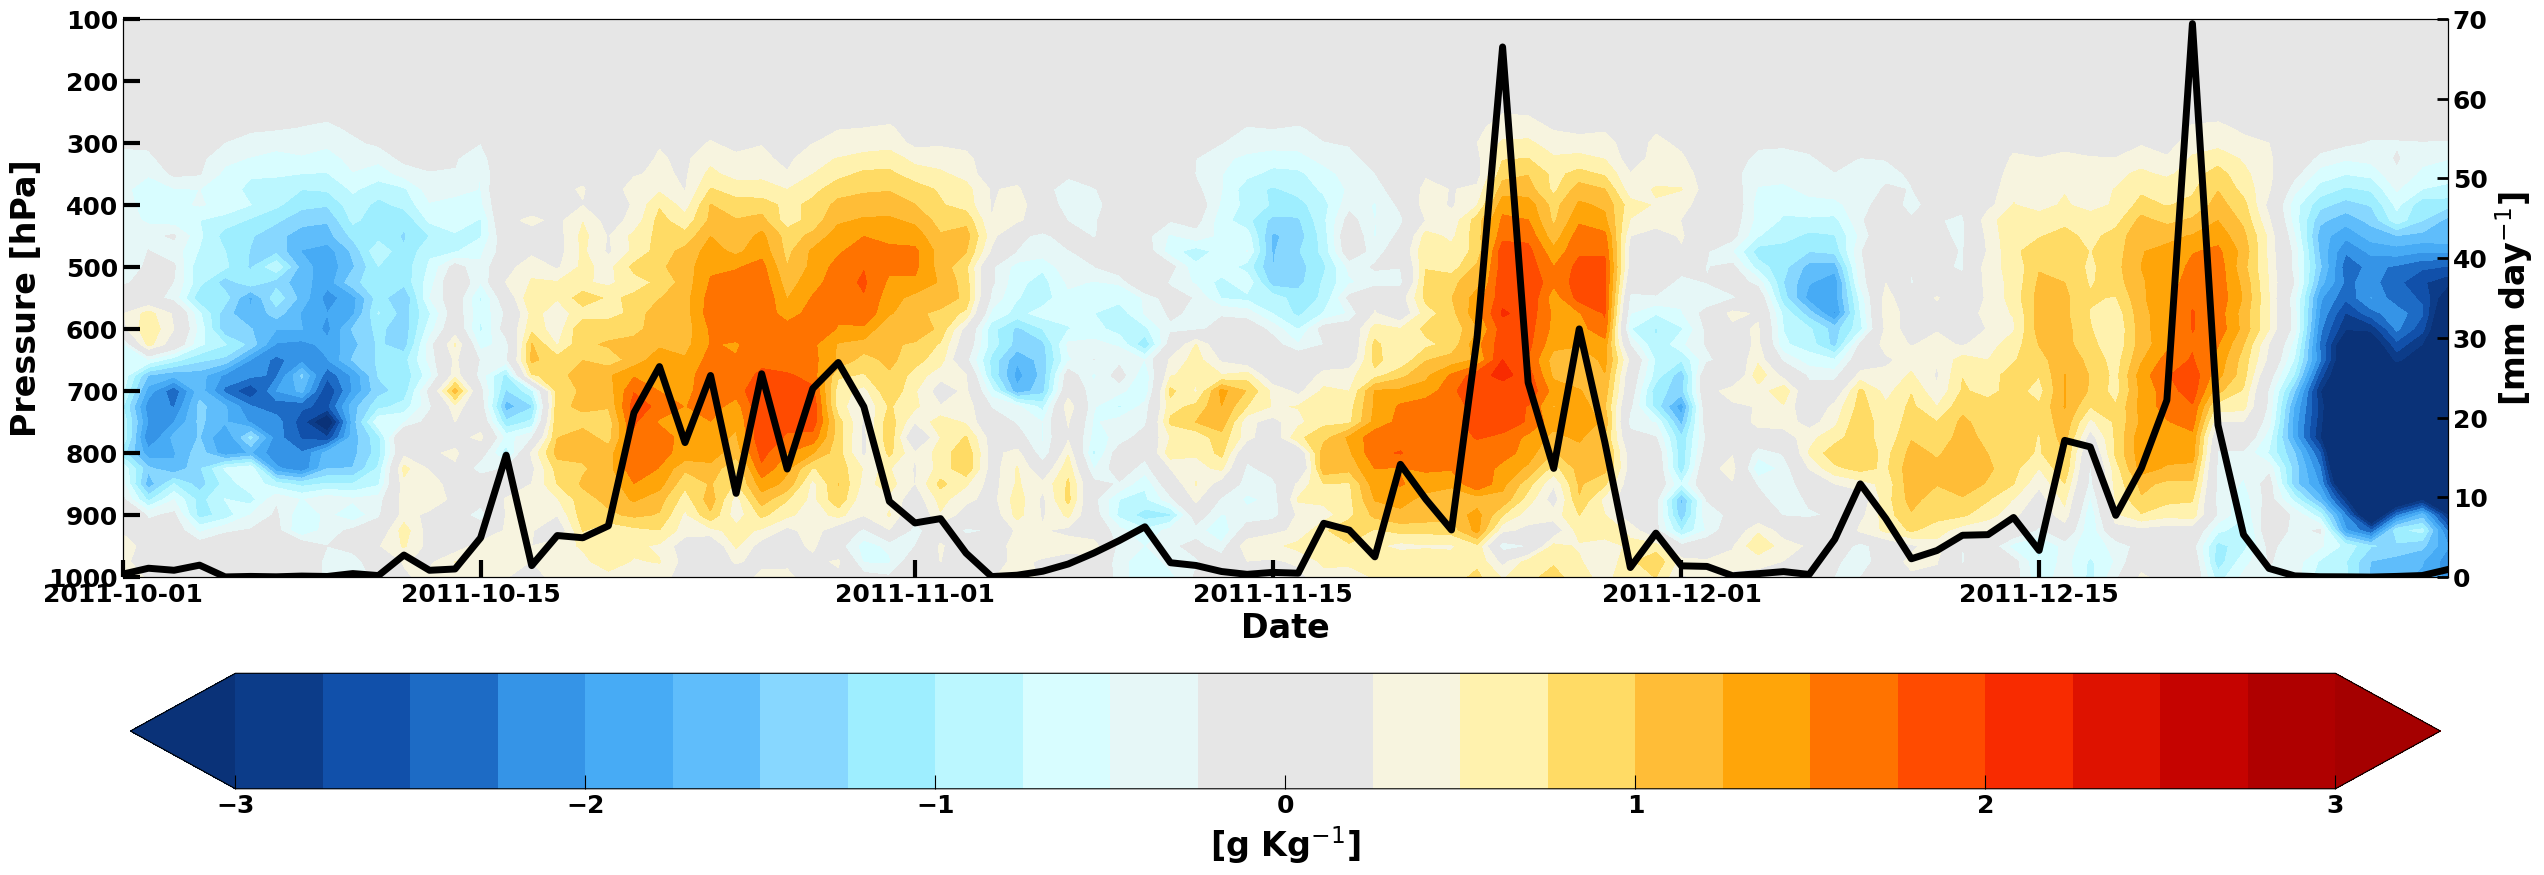

In [30]:
color_shading_var = (Q - Q.mean('time'))*1000
color_shading_levels = np.arange(-3, 3.25, 0.25)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[g Kg$^{-1}$]'
scientific_colorbar_boolean = False
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_specific_humidity_timeseries_time_mean_removed.png'


plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Temperature profile timeseries with the time mean removed 

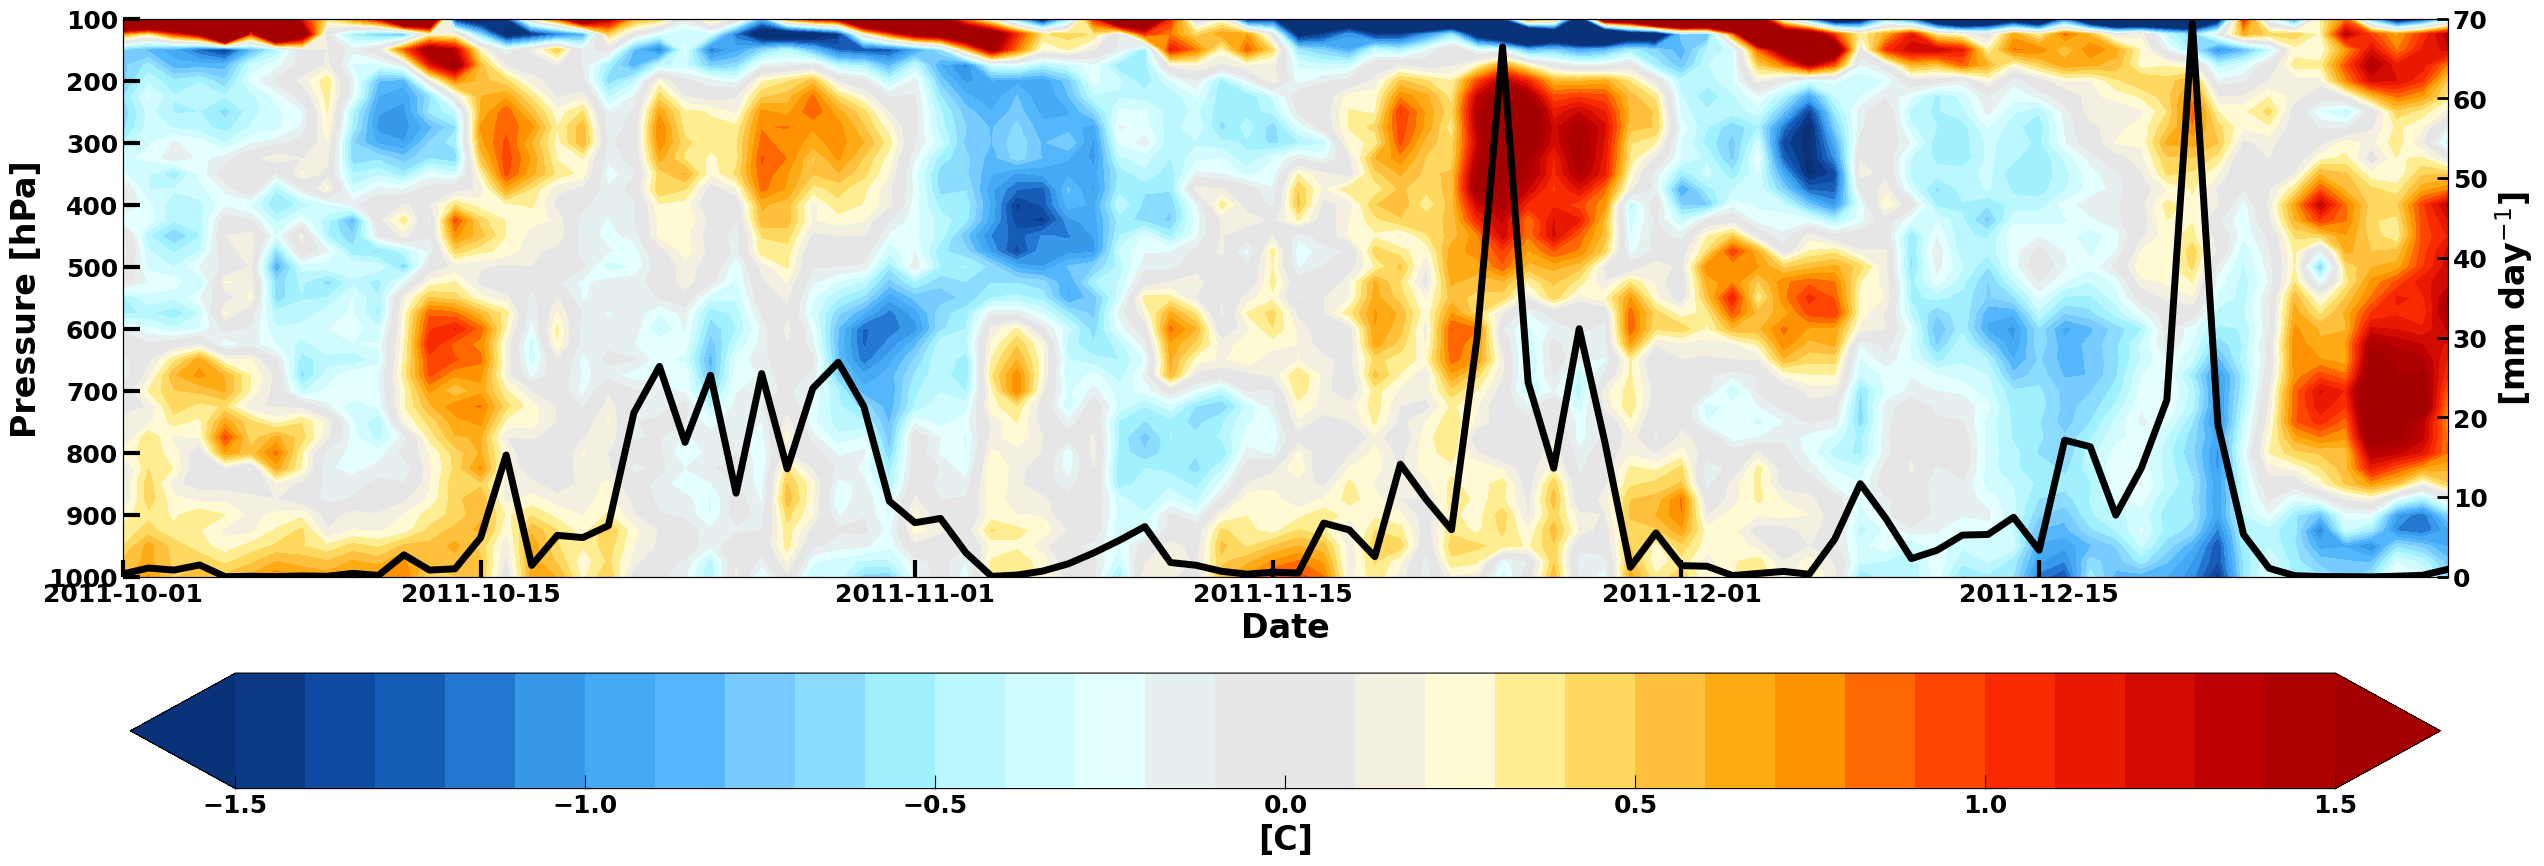

In [31]:
color_shading_var = (T - T.mean('time'))
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-1.5, 1.6, 0.1)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-1.5, 1.75, 0.5)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_temperature_timeseries_time_mean_removed.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Difference between Plume NOMIX Tv and Environment Tv

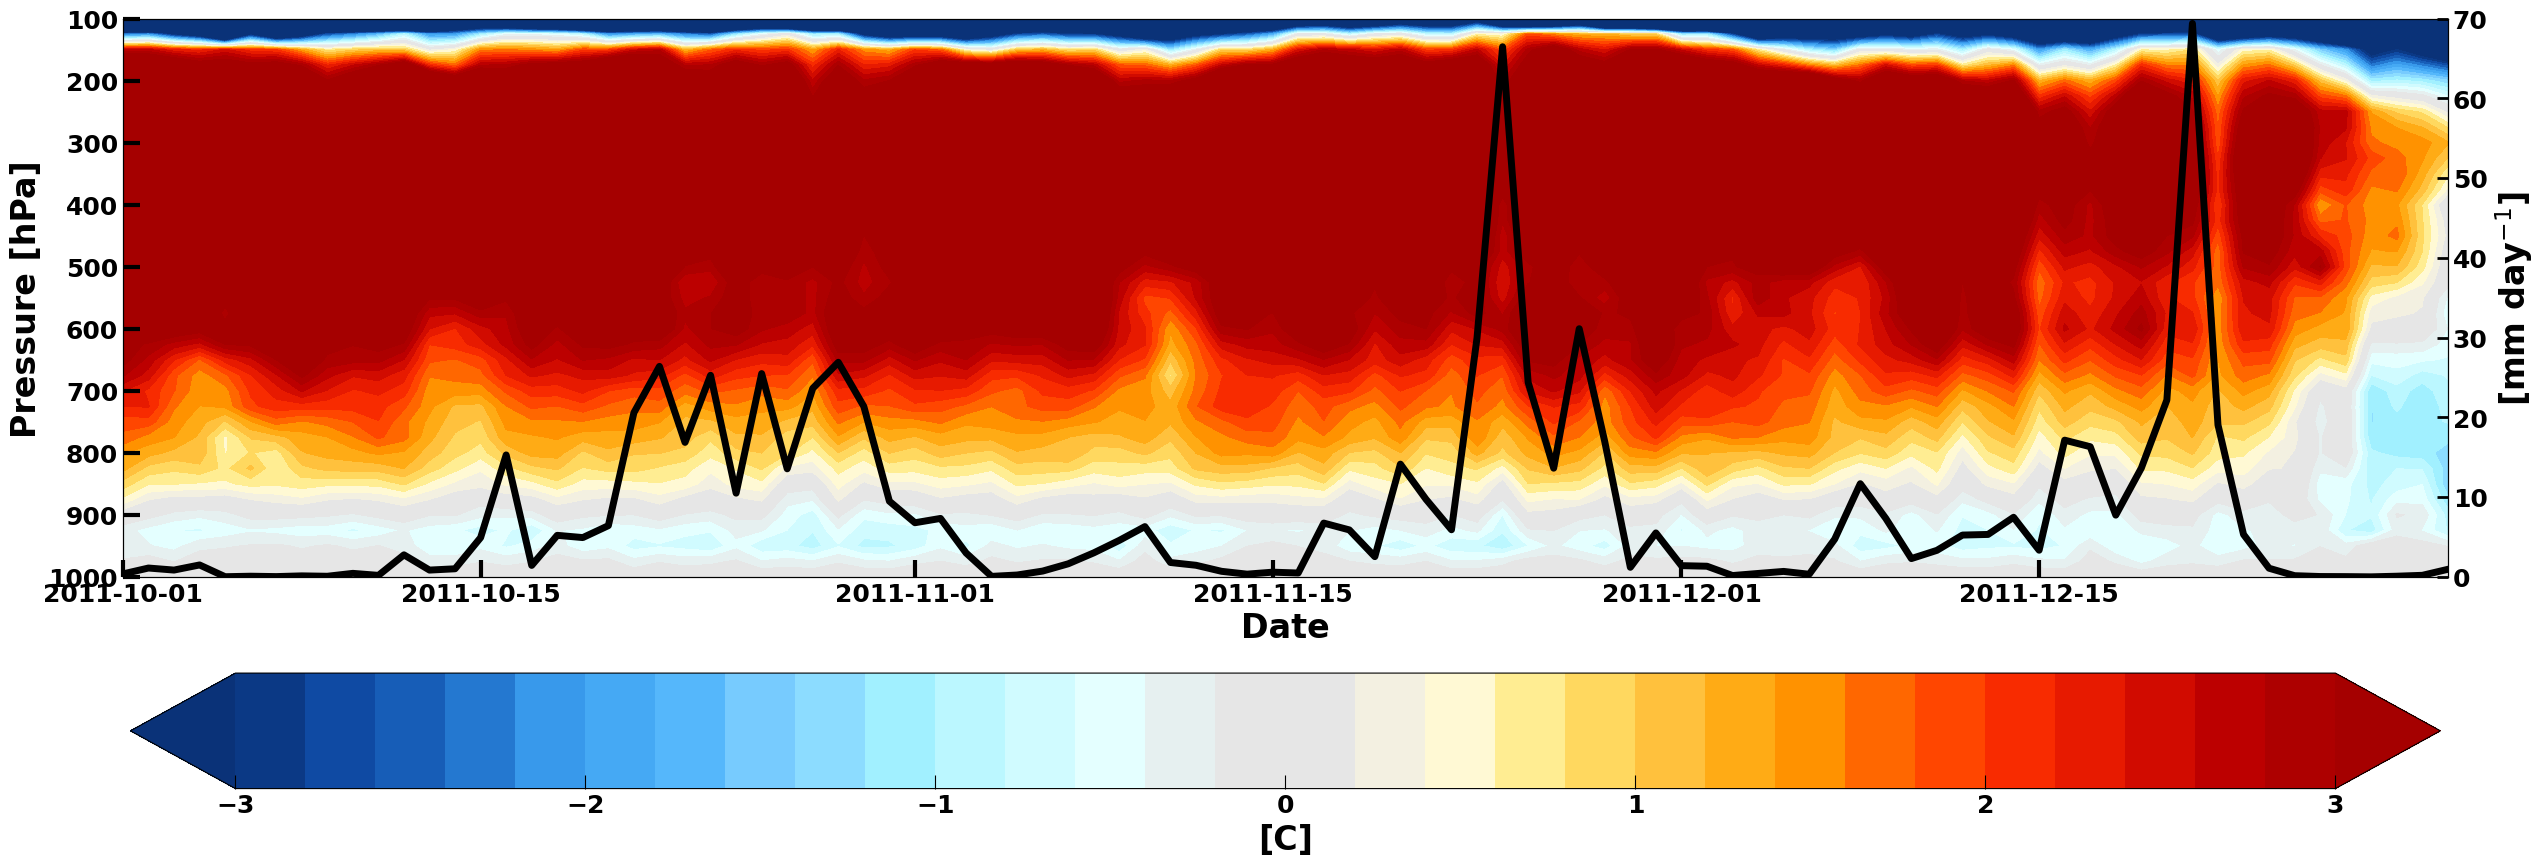

In [32]:
color_shading_var = Tv_plume_NOMIX - Tv_env
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-3, 3.2, 0.2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_plume_NOMIX_minus_Tv_env_timeseries.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Difference between Plume DIB Tv and Environment Tv

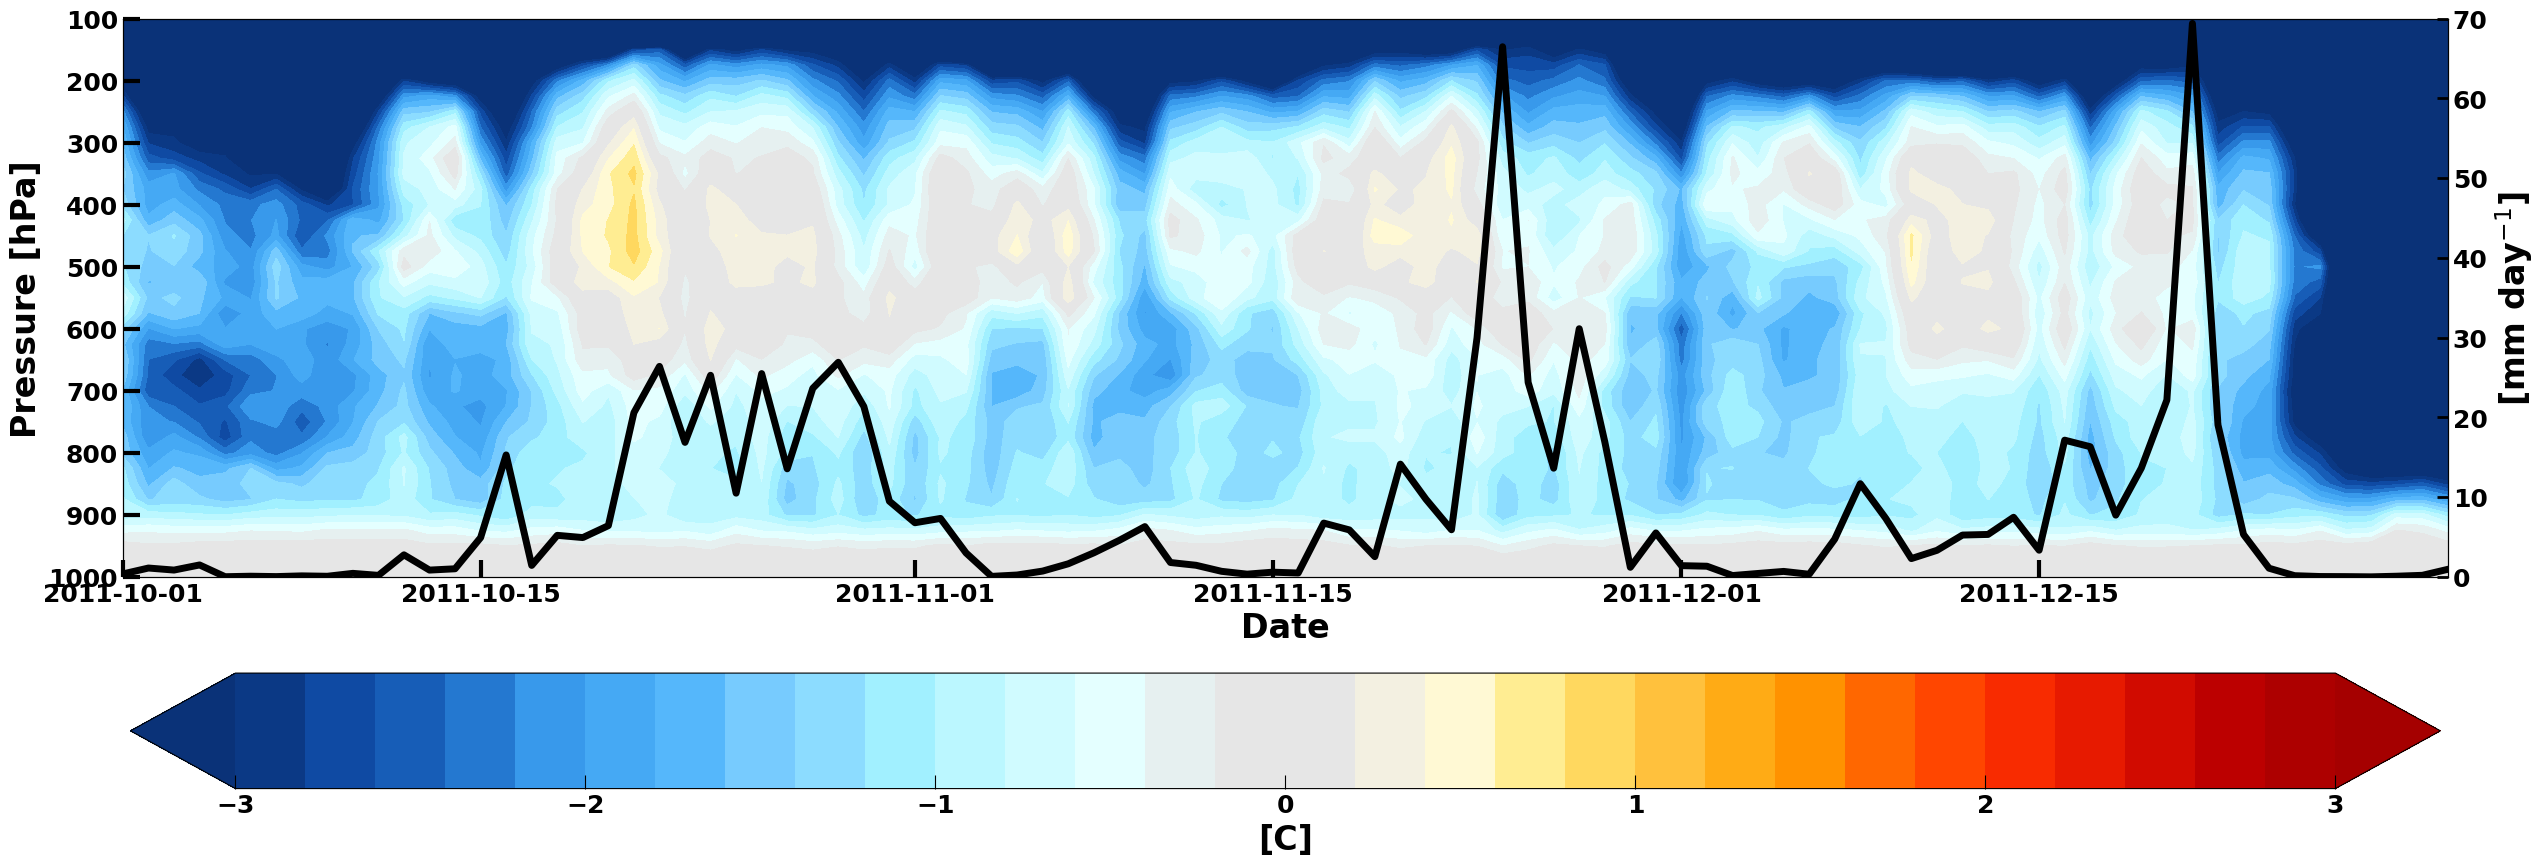

In [33]:
color_shading_var = Tv_plume_DIB - Tv_env
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-3, 3.2, 0.2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_plume_DIB_minus_Tv_env_timeseries.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Difference between Plume DIB Tv and Plume NOMIX Tv

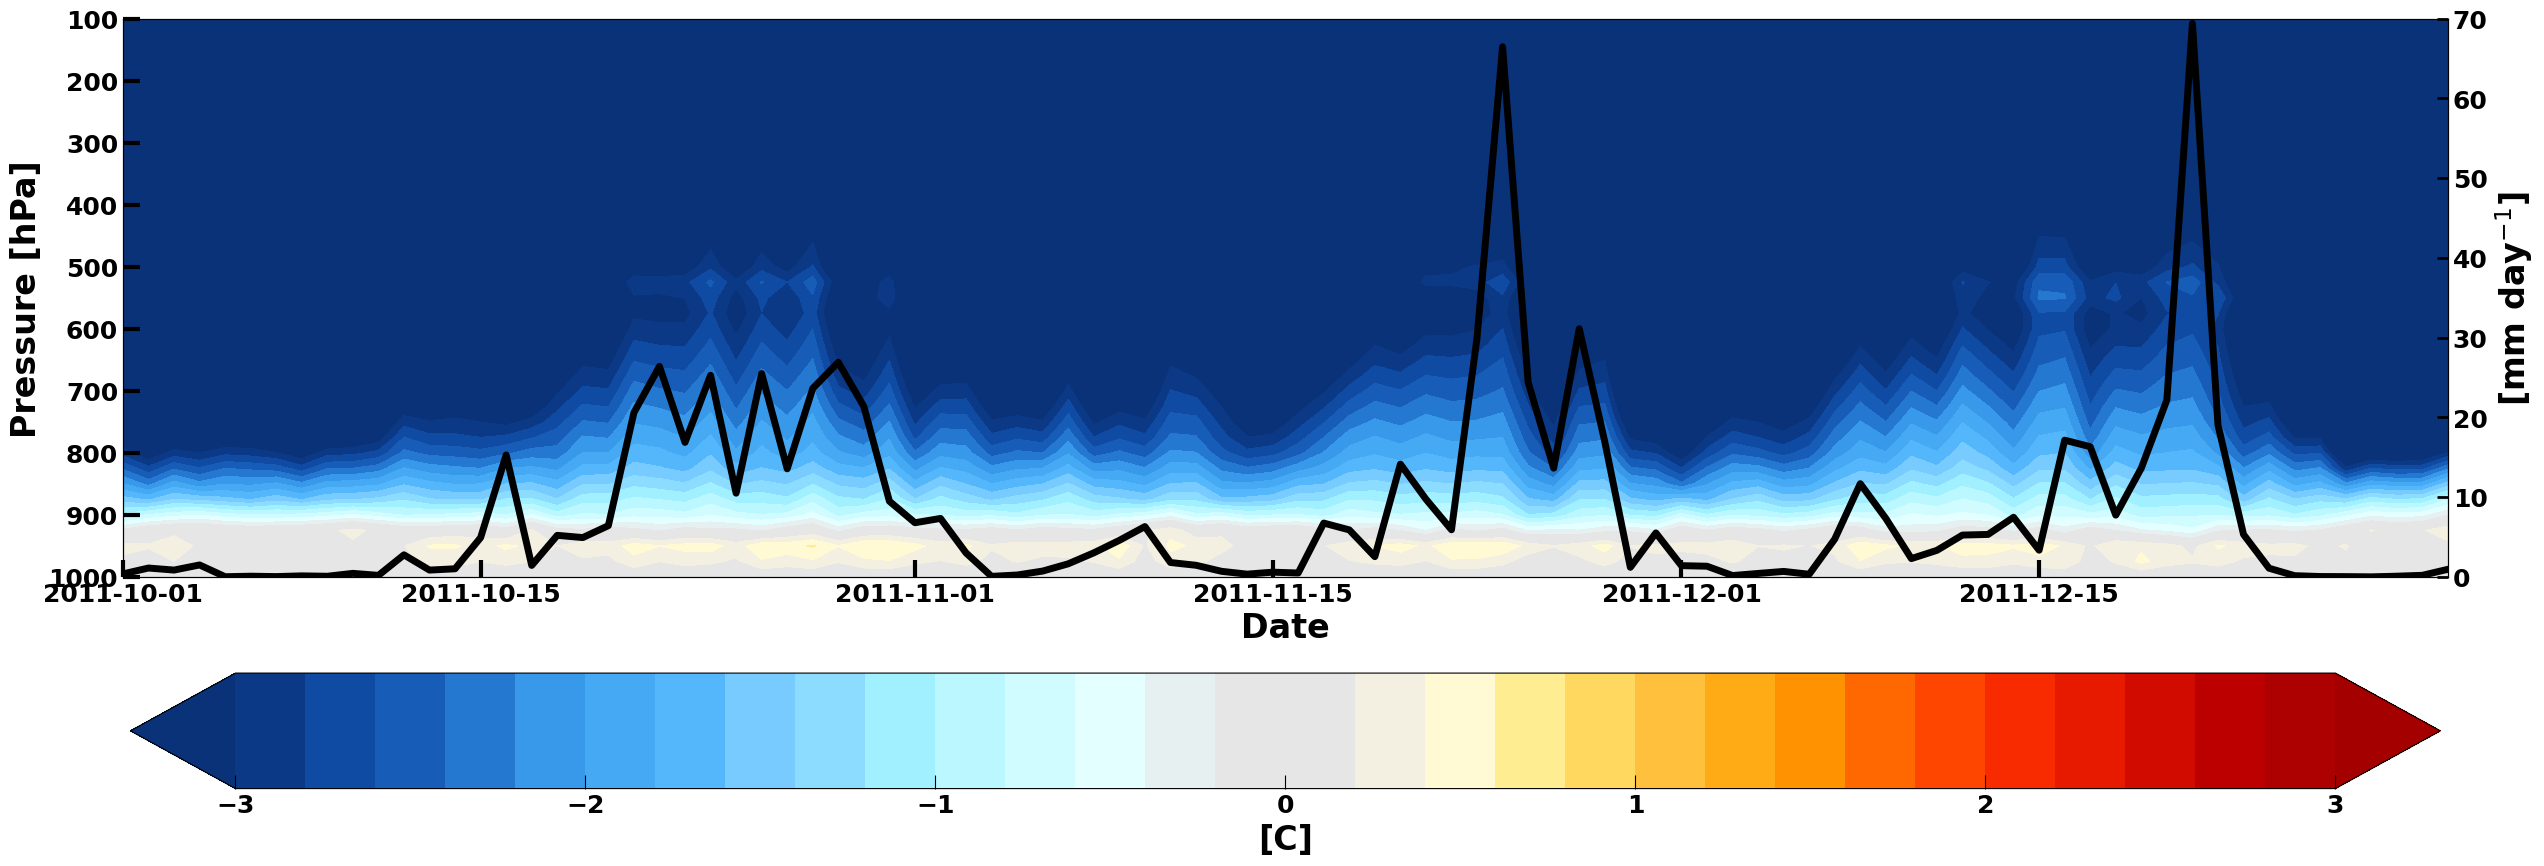

In [34]:
color_shading_var = Tv_plume_DIB - Tv_plume_NOMIX
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-3, 3.2, 0.2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_plume_DIB_minus_Tv_plume_NOMIX_timeseries.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Difference between Plume NOMIX Tv and Environment Tv with time mean removed

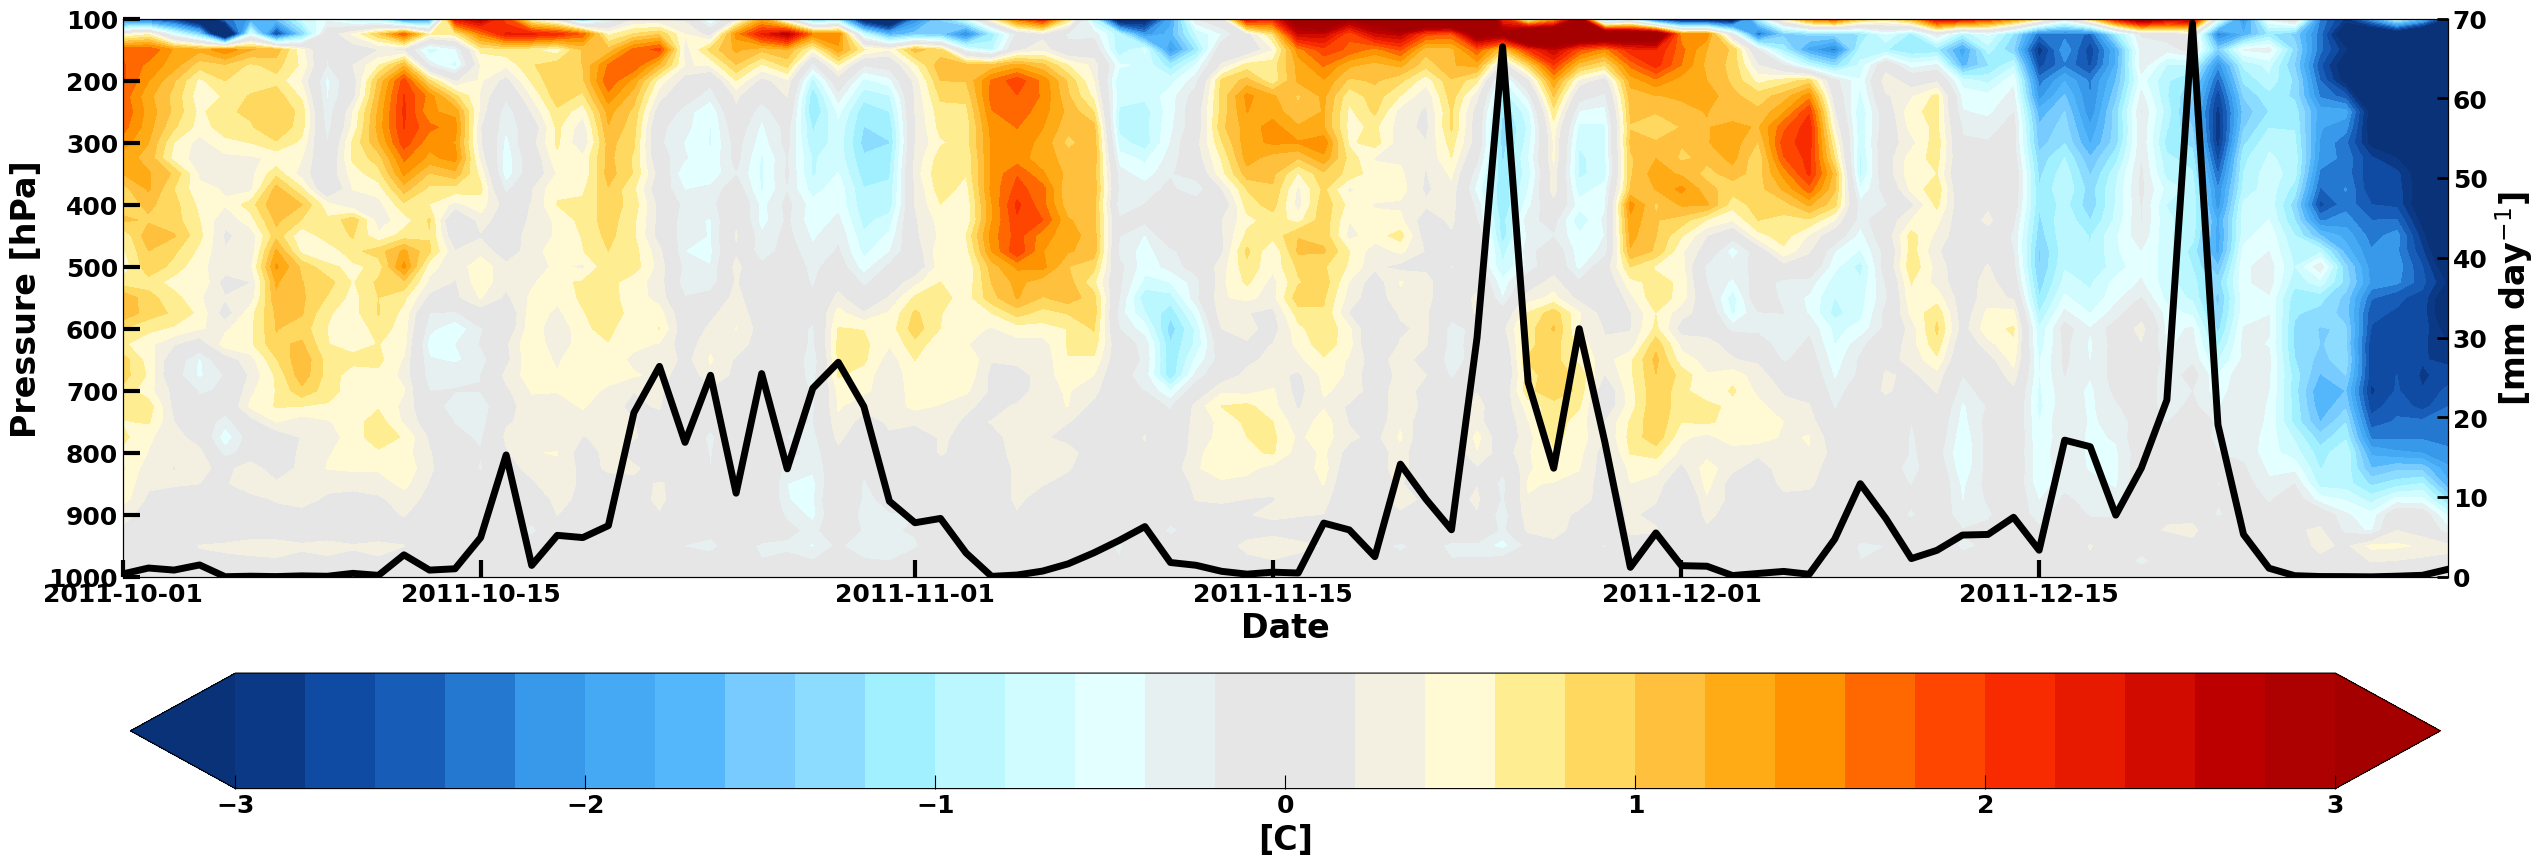

In [35]:
color_shading_var = (Tv_plume_NOMIX - Tv_env) - (Tv_plume_NOMIX - Tv_env).mean('time')
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-3, 3.2, 0.2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_plume_NOMIX_minus_Tv_env_timeseries_time_mean_removed.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Difference between Plume DIB Tv and Environment Tv  with time mean removed

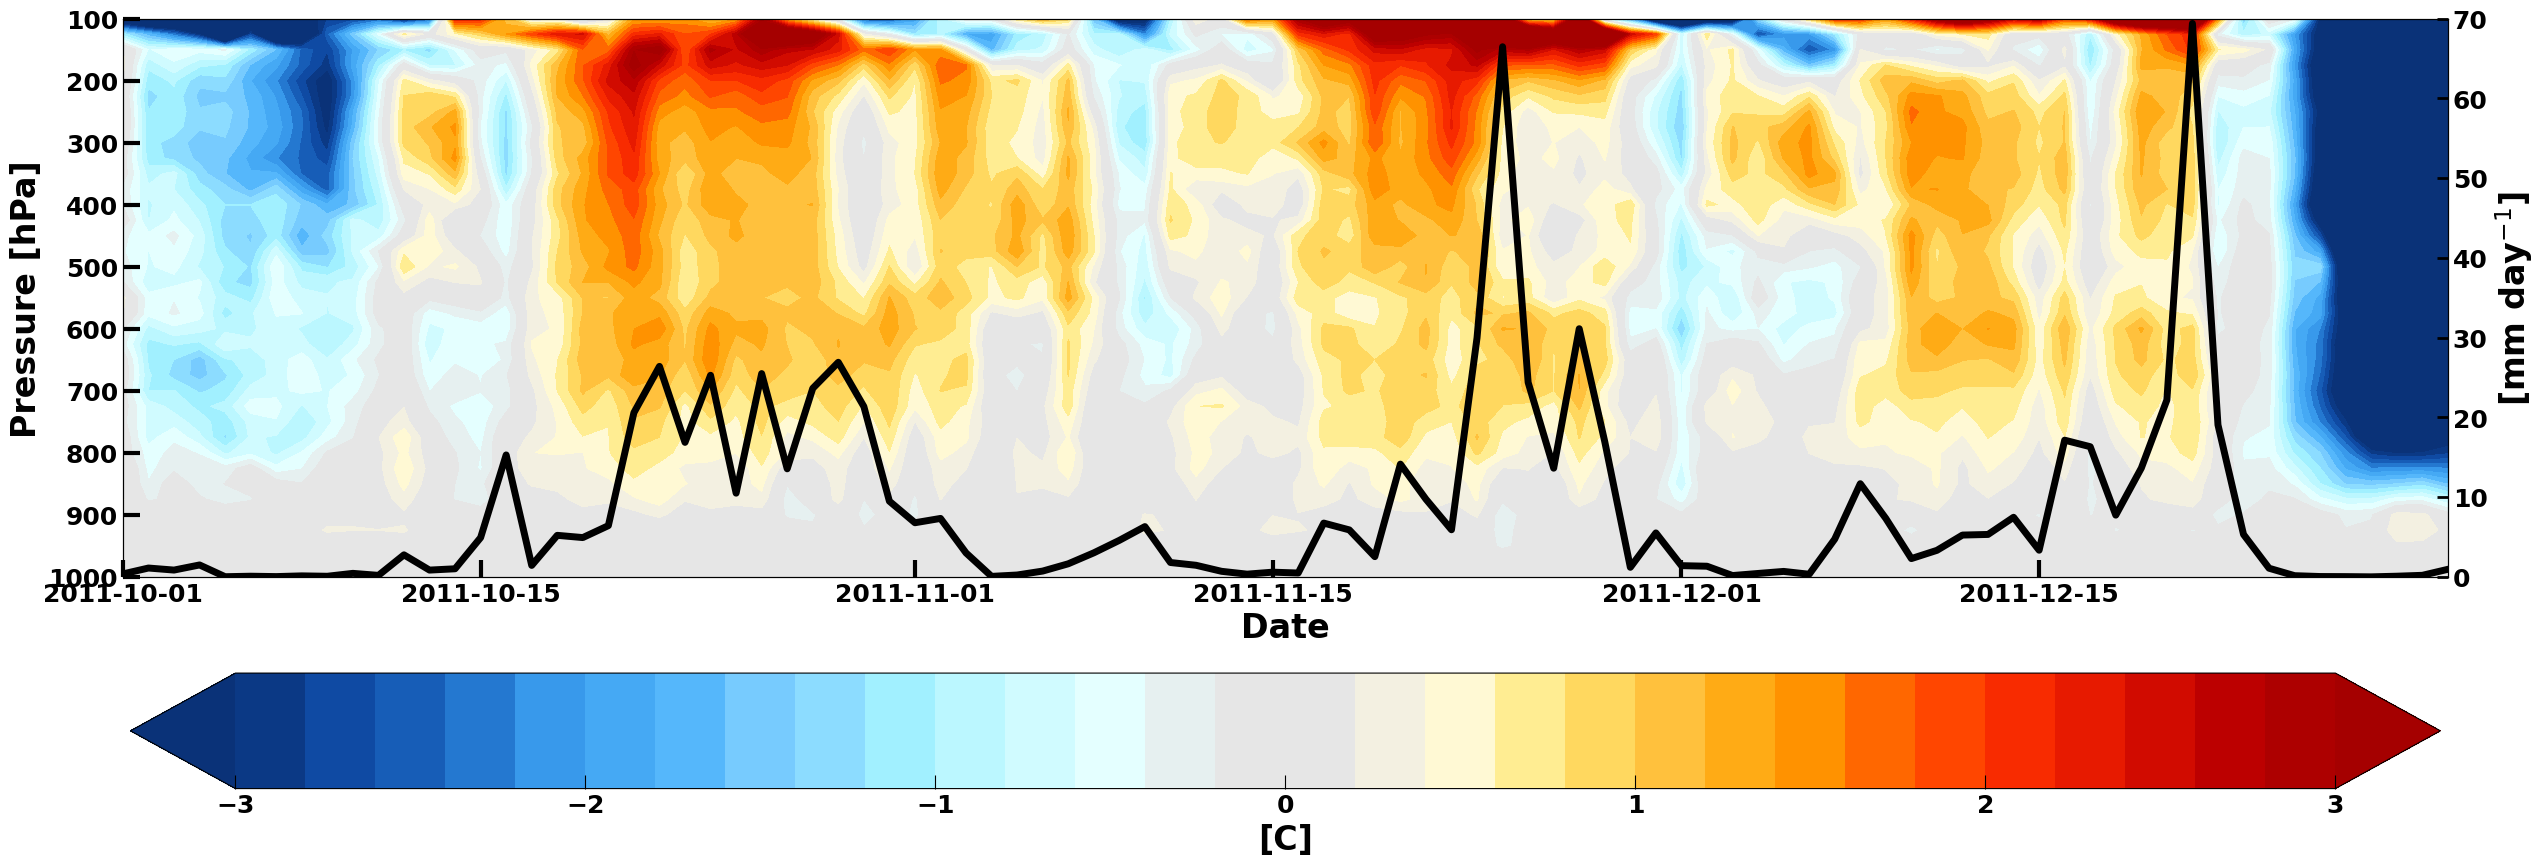

In [36]:
color_shading_var = (Tv_plume_DIB - Tv_env) - (Tv_plume_DIB - Tv_env).mean('time')
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-3, 3.2, 0.2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_plume_DIB_minus_Tv_env_timeseries_time_mean_removed.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)

# Difference between Plume DIB Tv and Plume NOMIX Tv with time mean removed

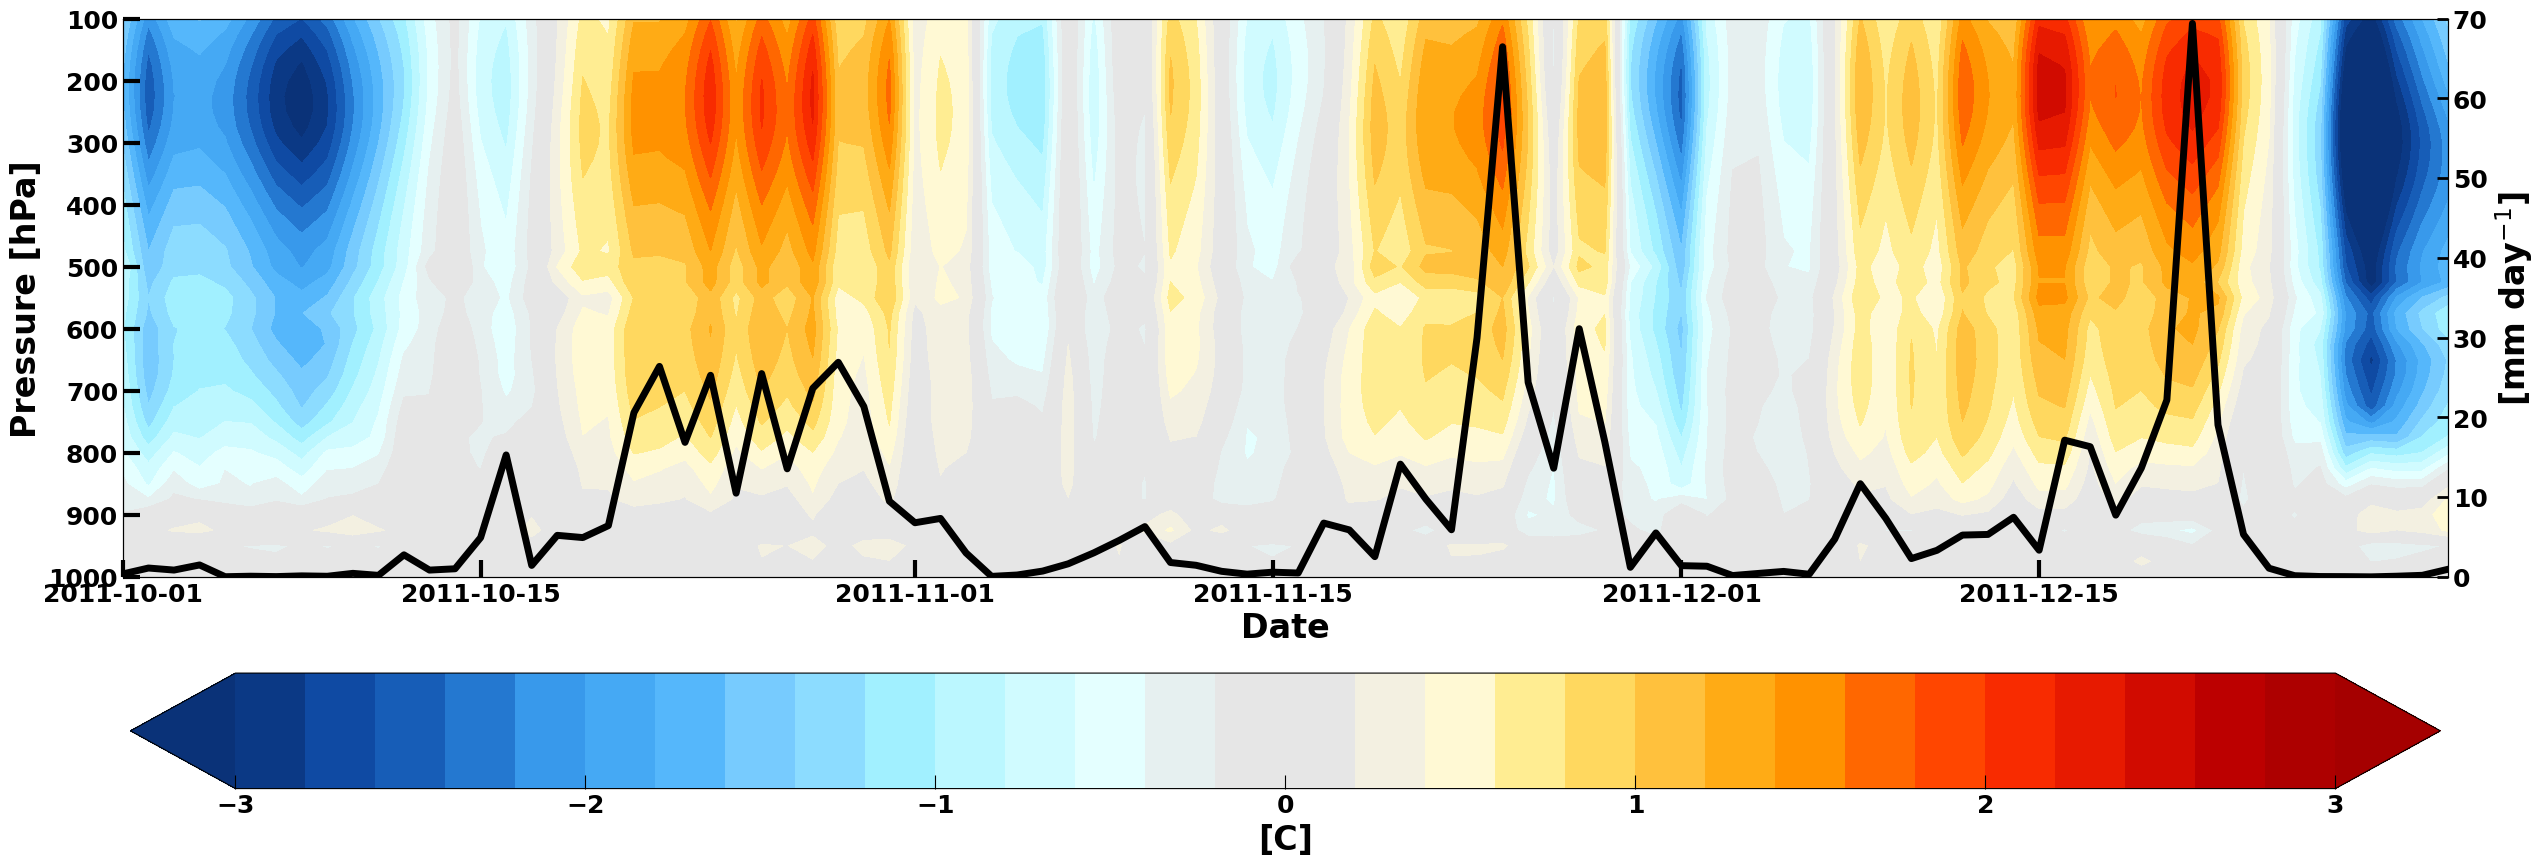

In [37]:
color_shading_var = (Tv_plume_DIB - Tv_plume_NOMIX) - (Tv_plume_DIB - Tv_plume_NOMIX).mean('time')
x_axis_limits = (color_shading_var.time.isel(time=0).values, color_shading_var.time.isel(time=-1).values)
y_axis_limits = (1000, 100)
x_axis_label = 'Date'
y_axis_label = 'Pressure [hPa]'
log_Y_axis_boolean = False
color_shading_levels = np.arange(-3, 3.2, 0.2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-3, 4, 1)
colorbar_label_string = '[C]'
scientific_colorbar_boolean = False
save_fig_boolean = True
figure_path_and_name = odir_plots + 'DYNAMO_NSA_V3b_Tv_plume_DIB_minus_Tv_plume_NOMIX_timeseries_time_mean_removed.png'

plot_precipitation_boolean = True
precipitation_y_axis_limits = (0, 70)
precipitation_y_axis_label = '[mm day$^{-1}$]'

plot_DYNAMO_NSA_profile_timeseries(color_shading_var, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, log_Y_axis_boolean, plot_precipitation_boolean, precipitation, precipitation_y_axis_limits, precipitation_y_axis_label, save_fig_boolean, figure_path_and_name)